# Fiducial Marker-Based Tracking and Compensation

This example demonstrates the fiducial marker-based motion tracking and compensation capabilities of **pyIDI**.

The example dataset originates from infrared-spectrum measurements. For convenience and to meet GitHub storage limits, the original data was undersampled to create a 25-frame video. The package can also process visible-range acquisitions.

---

#### Contact Information

For further details, please contact:

- **dr. Janko Slavič**  
  GitHub: [@jankoslavic](https://github.com/jankoslavic)  
  Email: janko.slavic@fs.uni-lj.si

- **dr. Lorenzo Capponi**  
  GitHub: [@LolloCappo](https://github.com/LolloCappo)  
  Email: lorenzo.capponi@fs.uni-lj.si

---

#### Acknowledgments

This work was conducted as part of the **ARTEMIDE** project, funded by the European Research Agency (ERA) under the Marie Skłodowska-Curie Actions (MSCA), Grant Agreement No. **101180595**.


# Showcase

In [2]:
# --- Import required libraries ---

import pyidi.fiducial as fid      # Fiducial marker handling from pyIDI
from sdypy.io import sfmov        # Import for handling .sfmov IR video format
import matplotlib.pyplot as plt   # For plotting

# Suppress resource-related warnings (optional)
import warnings
warnings.simplefilter("ignore", ResourceWarning)


In [3]:
# --- Load the video file ---

# Path to the input video file
filename = "../data/data_fiducial.sfmov"

# Load video data using sdypy.io
data = sfmov.get_data(filename)

Text(0.5, 1.0, 'Frame-0')

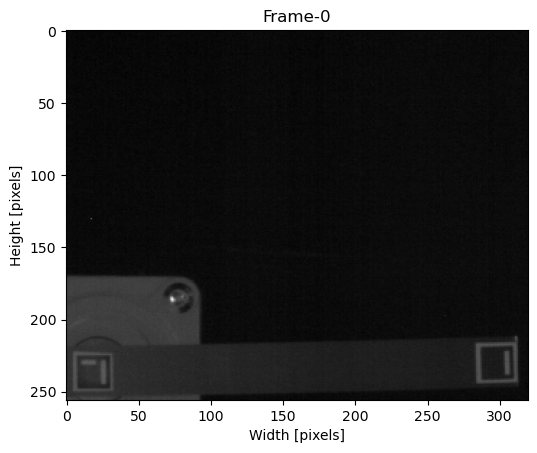

In [4]:
# --- Optional: Visualize a single frame from the video ---

fig, ax = plt.subplots()
ax.imshow(data[0], cmap='gray')
ax.set_xlabel('Width [pixels]')
ax.set_ylabel('Height [pixels]')
ax.set_title('Frame-0')

In [5]:
# --- Create an instance of the Fiducial class ---

# `data` must be a NumPy array with shape:
# (num_frames, height, width, channels) for RGB or
# (num_frames, height, width) if grayscale

test = fid.Fiducial(data)

In [6]:
# --- Optional: Basic preprocessing of video frames to improve marker detection ---

processed_video = test.pre_process(
    clip_range=(19.4, 20.0),
    enhance_contrast=True
)

Preprocessing input video: 100%|██████████| 25/25 [00:00<00:00, 2286.67it/s]


Text(0.5, 1.0, 'Frame-0 processed')

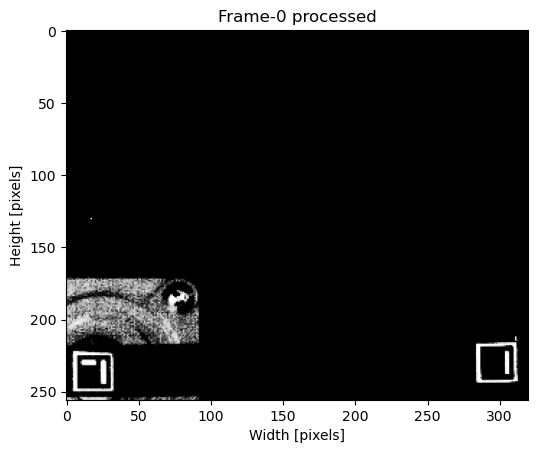

In [7]:
# --- Optional: Visualize a single frame from the processed video ---

fig, ax = plt.subplots()
ax.imshow(processed_video[0], cmap='gray')
ax.set_xlabel('Width [pixels]')
ax.set_ylabel('Height [pixels]')
ax.set_title('Frame-0 processed')

In [8]:
# --- Fiducial Marker Detection ---

# Define the marker type ('aruco', 'apriltag', etc.)
marker_type = 'aruco'

# Specify the ArUco dictionary (optional: autodetection if not specified)
fiducial_dictionary = 'DICT_ARUCO_ORIGINAL'

# Define known marker IDs to detect/track (optional: detect all if not specified)
known_ids = {0, 1}

# Detect markers across all frames in the processed video
fiducial_original = test.detect_markers(
    processed_video,
    marker_type=marker_type,
    fiducial_dictionary=fiducial_dictionary,
    known_ids=known_ids
)

Detection Progress of Fiducial Markers: 100%|██████████| 25/25 [00:00<00:00, 820.04it/s]

Detection Success Rate: 100.0%


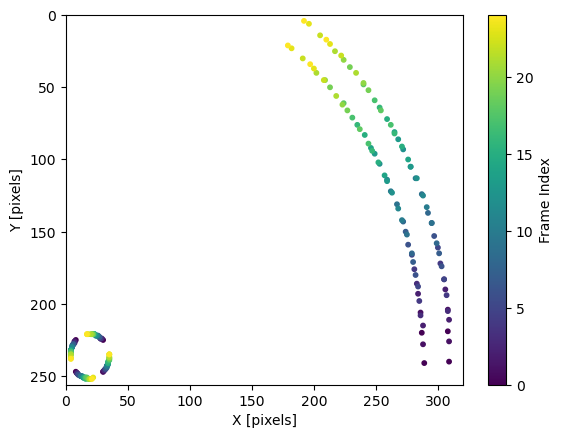

In [9]:
# --- Optional: Visualize the position of the detected markers' corners ---

ox, oy, oc = zip(*[
    (x, y, i)
    for i, frame in enumerate(fiducial_original)
    for _, corners in frame
    for x, y in corners
])

fig, ax = plt.subplots()
sc = ax.scatter(oy, ox, c=oc, s=10, cmap='viridis')
ax.invert_yaxis()
ax.set_xlabel('X [pixels]')
ax.set_ylabel('Y [pixels]')
ax.set_xlim([0,data.shape[2]])
ax.set_ylim([data.shape[1],0])
fig.colorbar(sc, ax=ax, label='Frame Index')

In [10]:
# --- Optional: Determine ArUco dictionary used ---

# If using ArUco markers and unsure of the dictionary, pass any frame to detect it
fiducial_dictionary = test.determine_aruco(processed_video[0])

print(f"Detected ArUco dictionary: {fiducial_dictionary}")

Detected ArUco dictionary: DICT_ARUCO_ORIGINAL


In [11]:
# --- Compute transformation matrices from each frame to the reference frame ---

# Transformation type: 'euclidean' (default), 'affine', or 'homography'
transformation = 'euclidean'

# Index of the reference frame
ref = 24

# Compute transformation matrices
transformation_matrices = test.compute_transformations(
    fiducial_original,
    reference_index=ref,
    transform_type=transformation
)

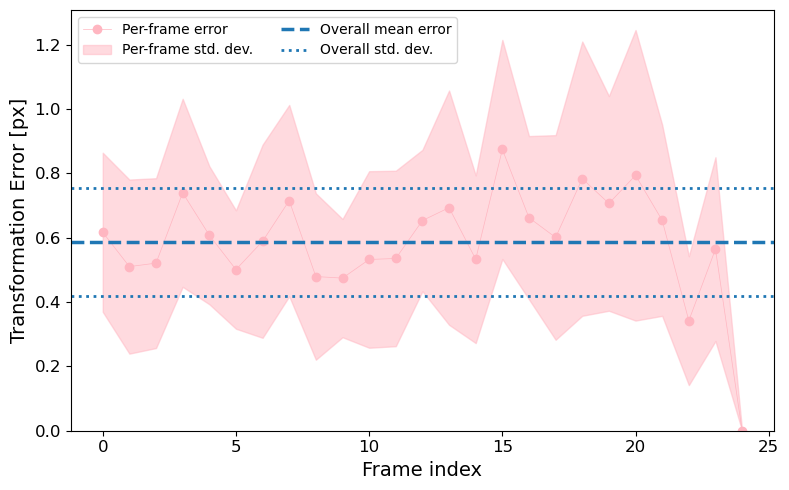

{'Mean Error': 0.587106511592865, 'Standard Deviation': 0.16738125367689038}


In [12]:
# --- Optional: Revert transformations using fiducial markers ---

# This step is used to evaluate the quality of the transformations
# based solely on the fiducial marker coordinates.
# Plotting the results is also optional but useful for visual verification.

# Apply the inverse of the transformation matrices to the detected markers
fiducial_reverted = test.revert_fiducial(fiducial_original, transformation_matrices)

# Perform uncertainty analysis between original and reverted marker positions
stats = test.uncertainty_analysis(
    fiducial_original,
    fiducial_reverted,
    plot=True  # Set to False if you want to skip plotting
)

# Print summary statistics of transformation accuracy
print(stats)

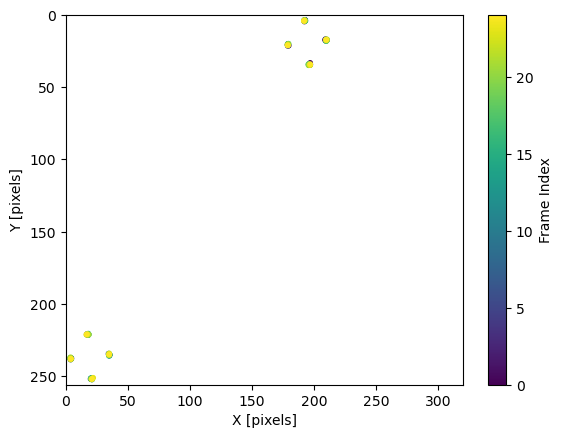

In [13]:
# --- Optional: Visualize the position of the reverted markers' corners ---

cx, cy, cc = zip(*[
    (x, y, i)
    for i, frame in enumerate(fiducial_reverted)
    for _, corners in frame
    for x, y in corners
])

fig, ax = plt.subplots()
sc = ax.scatter(cy, cx, c=cc, s=10, cmap='viridis')
ax.invert_yaxis()
ax.set_xlabel('X [pixels]')
ax.set_ylabel('Y [pixels]')
ax.set_xlim([0,data.shape[2]])
ax.set_ylim([data.shape[1],0])
fig.colorbar(sc, ax=ax, label='Frame Index')


In [14]:
# --- Compensate entire video frames using transformation matrices ---

# Apply inverse transformations to all video frames to compensate for motion/rotation
data_compensated = test.revert_frames(
    transformation_matrices,
    transform_type=transformation
)

Reverting frames to reference: 100%|██████████| 25/25 [00:00<00:00, 443.20it/s]
